In [1]:
%pylab inline
import poppy
import astropy.units as u

Populating the interactive namespace from numpy and matplotlib


_Thanks to Derek Sabatke (Ball Aerospace), Alden Jurling and Tom Zielinski (NASA GSFC), and Randal Telfer (STScI) for invaluable discussions and contributions in disambiguating this oft-treacherous topic._

We begin by stating the basic conventions assumed for spatial and angular coordinates, then move on to the more subtle issues of wavefront error and optical propagation sign conventions. 

# Spatial Coordinate Conventions for Pupil Planes and Image Planes

`Poppy` adopts a right-handed coordinate system as follows. The $z$ axis is the optical axis of propagation, with $+z$ being in the direction of travel as usual. In the plane of an optic, the $+y$ axis is vertical upwards. Following the right hand rule, if looking from an image plane towards an object plane (i.e. looking "outward from the detector", in the $-z$ direction), the $+x$ axis points toward the right. 

<br clear='all' />
<img src="poppy_pupil_axes_convention.png" width=700 align='center' />
<br clear='all' />

This convention has the convenient property that the $+x$ and $+y$ axes are consistent with `matplotlib` display conventions, assuming you use the `origin="lower"` display option to set the image axes origin to lower left. This display setting is applied automatically in all display functions in `poppy`. 

We note this axes convention also matches that used in Code V, among other programs. 

Image plane axes follow the same convention. This corresponds to the typical astronomical convention of "images as projected looking out onto the sky", and in particular matches the output image axes convention for the Hubble and JWST image processing pipelines (and the vast majority of astronomical software worldwide). 
 

*A note on reimaged pupils*: By convention and for convenience, `poppy` by default models all pupils in a system on consistent axes matching that of the system exit pupil; it does _not_ automatically model the inversion or flip at reimaged pupils. This is intended as a practical convenience to ease calculations on pupils without having to consider possibly-different coordinate signs for each pupil. If your use case requires modeling the spatial flip at reimaged pupils, add the coordinate inversion explicitly via a `poppy.CoordinateInversion` instance.   For instance, this is done in `webbpsf` since the convention for the JWST primary is to represent it as in entrance pupil orientation seen from in front of the telescope; a `CoordinateInversion` is used to flip this to the exit pupil orientation before the optical propagations in the optical system model. Similarly, any intermediate image planes in a system are modeled with coordinates consistent with the final image plane. 


## Position Angles

In a pupil or image plane, rotation angles are defined increasing counterclockwise. In other words a rotation from the $+x$ axis toward the $+y$ axis is positive. 

This definition is consistent with the common astronomical convention of measuring angles counterclockwise from North towards East as projected onto the sky. It's also consistent with the convention used by Wyant and Creath (their Figure 4B), who note that it matches the convention used in various optical interferogram analyses packages. 

# Sign Conventions for Phase, Wavefront Error and OPD

   _The devil is in the details, and the details are all sign conventions. --Anonymous_



## Sign Conventions for Wavefront

We follow the optics convention that _an advanced wavefront corresponds to a positive optical path difference_.  This follows e.g. [Wyant and Creath's Basic Wavefront Aberration Theory](https://wp.optics.arizona.edu/jcwyant/wp-content/uploads/sites/13/2016/08/03-BasicAberrations_and_Optical_Testing.pdf). We quote from their Section 1 on Sign Conventions:

> The optical path difference (OPD) is defined as the difference between the aberrated and the ideal unaberrated wavefronts. The OPD is positive if the aberrated wavefront leads the ideal unaberrated wavefront as shown in Fig. 2. Also, if the aberrated wavefront curves in more than the unaberrated wavefront, the OPD is positive. Therefore, a negative focal shift will introduce a positive aberration, so that a positive aberration will focus in front of the Gaussian image plane, as shown in Fig. 3. In the case of interferometric optical testing, this means that a bump on a test mirror (aberrated beam) will be represented by a bump in the OPD.


<BR clear='all' />
<img src="fig_wyant_creath_sign_convention_fig2.png" width=400 align='left' />
<img src="fig_wyant_creath_sign_convention_fig3.png" width=400 align='right' />
<BR clear='all' />


Thus in the case of a segmented telescope, advancing one segment forward (towards the secondary) should be represented as positive wavefront error over the area of that segment. 


**Optical Path Difference vs. Optical Path Length:**

An alternative phrasing that arrives at the same place is as follows. We can define the *optical path length* (OPL) as the sum of distances across ray segments; this is intuitive, easy to calculate, and essentially free of sign conventions. With that definition in mind we can state:

> A longer optical path length causes a ray’s phase to lag, so that corresponds to a negative wavefront error.

"Lag" in this context means that the propagation time is larger along that longer path.  With that in mind we can then relate:

```
OPD = WFE = aberrated_wavefront - unaberrated_wavefront = constant - OPL
```


## Sign conventions used in optical propagation. 


The sign of the phase term in expressions for complex amplitude depends on your choice of an arbitrary sign in the complex exponential $exp[±i(ωt - kr)]$, where $r$ is propagation distance and $k= 2π/λ$.  So if we’ve got an aberrated wave propagating roughly along the $z$ axis, we’d say $r = z + OPL$.  We know the sign on OPL here because optical path length behaves like propagation distance. Plugging that in gives $exp(∓ik OPL) exp[±i(ωt - kz)]$, which technically answers the question, but is not so helpful until clarifying if you're using the signs on the top or the bottom. 

<font color='red'>TODO copy/adapt more text here based on Derek's very helpful email...</font>

> follow WAS’  lead here and use the top set of signs (increasing phase with time).

> The main point is that the Fourier transform should have + signs in the exponent for a basic left-to-right propagation from a real pupil to a real image


The [numpy sign convention for FFTs](https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft) uses a negative sign in the exponential for the forward transform `np.fft`, and a positive sign in the exponential for the inverse transform `np.ifft`. Thus we arrive at the conclusion that we need an inverse FFT for the forward propagation, and vice versa a forward FFT for backward propagation. 

We verify below that adopting this convention does result in PSFs consistent with expectations, in particular for tilts on wavefronts. 



# Test Cases and Verifications

## A Converging Wavefront has positive OPD

The OPD is positive if the aberrated wavefront leads the ideal unaberrated wavefront.  A converging wavefront leads at its outer edges relative to a flat wavefront. Here we create a converging wavefront and verify that it has positive wavefront aberration. 

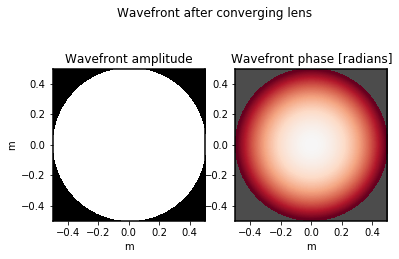

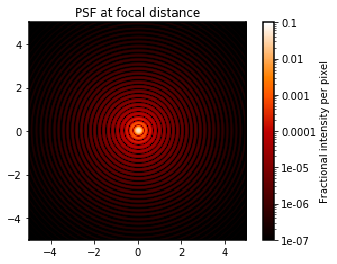

In [2]:
# Construct a converging optical system: 
focal_length = 1.0*u.m
osys = poppy.FresnelOpticalSystem(beam_ratio=0.25, pupil_diameter=1*u.m)
osys.add_optic(poppy.CircularAperture(radius=0.5*u.m))
lens = poppy.QuadraticLens(f_lens=focal_length, name="Converging lens")
osys.add_optic(lens)
osys.add_optic(poppy.ScalarTransmission(planetype=poppy.poppy_core.PlaneType.image, 
                                        name='focus'), 
               distance=focal_length);

psf, waves = osys.calc_psf(wavelength=1*u.micron, display=False, return_intermediates=True)

plt.figure()
waves[1].display(what='both')
plt.suptitle("Wavefront after converging lens")

assert np.all(waves[1].phase[waves[1].intensity != 0] >= 0), "Converging wave should have all positive phase"

plt.figure()
poppy.display_psf(psf, imagecrop=10, title='PSF at focal distance')

## OPD and WFE should have consistent signs and amplitudes

A positive bump on an optic (or, equivalently, a positive perturbation on a segmented or deforamable mirror) should produce positive wavefront error in a beam that encounters that optic. 

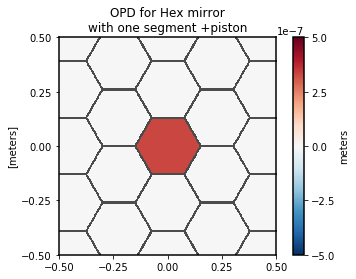

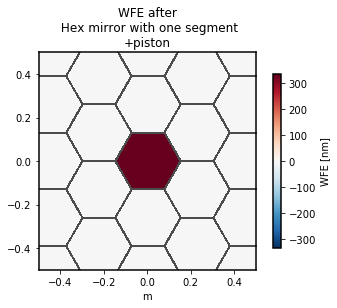

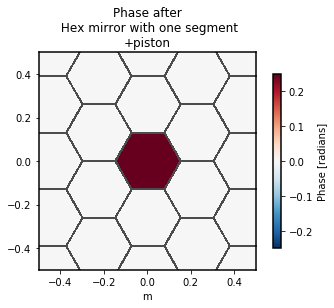

In [117]:
wavelen = 1*u.micron

hexdm = poppy.HexSegmentedDeformableMirror(flattoflat=0.25*u.m, name='Hex mirror\nwith one segment +piston')
hexdm.set_actuator(0, wavelen/3, 0, 0 )  # apply some piston < 1/2 wave to avoid phase ambiguity

osys2 = poppy.OpticalSystem(pupil_diameter=1*u.m)
osys2.add_pupil(poppy.CircularAperture(radius=0.5*u.m))
osys2.add_pupil(hexdm)

wave = osys2.input_wavefront()
wave *= hexdm

# Display hex DM (zoomed in)
hexdm.display(what='opd', npix=1024, colorbar_orientation='vertical')
plt.gca().set_xlim(-0.5, 0.5)
plt.gca().set_ylim(-0.5, 0.5)

# display wavefront, as WFE and phase
plt.figure()
wave.display(what='wfe', colorbar=True)

plt.figure()
wave.display(what='phase', colorbar=True)

# Assert consistency
opd = hexdm.get_opd(wave)
where_valid = opd != 0
assert np.allclose(opd[where_valid].mean(), wave.wfe[where_valid].mean().value), \
    "OPD and WFE should be consistent, for cases avoiding phase wrapping"

# For a related automated unit test, see poppy.tests.test_sign_conventions.test_wfe_opd_consistency

# **Sign conventions for Tilts:**

Returning to Wyant and Creath: 

> Tilt in a wavefront affects the image by causing a shift of its center location in the Gaussian image plane. A tilt causing a positive OPD change in the +x direction will cause the image to shift in the -x direction, as shown in Fig. 5.

## A wavefront with positive OPD in +x should shift the image to -x

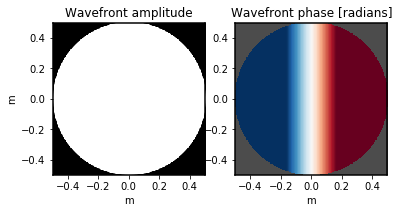

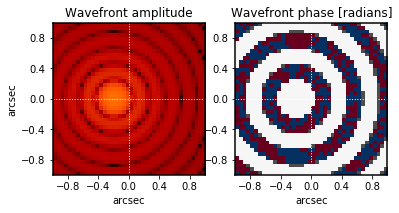

In [116]:
# Create a wavefront and apply a tilt
wave = poppy.Wavefront(diam=1*u.m, npix=256)
wave *= poppy.CircularAperture(radius=0.5*u.m)
    
tilt_angle = -0.2    # must be a negative number (for -X direction shift), and within the FOV

wave.tilt(Xangle=tilt_angle)  # for this function, the input is the desired direction for the image to tilt.
                              # A shift to -X is implemented by creating an OPD that increases toward +X
n = wave.shape[0]
assert wave.wfe[n//2, n//2-5] <  wave.wfe[n//2, n//2+5], "Wavefront error should increase to +X"

wave.display(what='both')

wave.propagate_to(poppy.Detector(pixelscale=0.05, fov_pixels=128))

plt.figure()
wave.display(what='both', crosshairs=True, imagecrop=2)

n = wave.shape[0]
cen = poppy.measure_centroid(wave.as_fits())
assert np.allclose(cen[0], (n-1)/2), "Tilt in X should not displace the PSF in Y"
assert cen[1] < (n-1)/2, "WFE tilt increasing to +X should displace the PSF to -X"
assert np.allclose(((cen[1]-(n-1)/2)*u.pixel*wave.pixelscale).to_value(u.arcsec), tilt_angle), "PSF offset did not match expected amount"


# For a automated unit test version of this, see poppy.tests.test_sign_conventions.test_wavefront_tilt_sign_and_direction

A more complicated example, with multiple tilted segments in a deformable mirror. We tilt one segment to move its spot toward -X, and another to move its spot toward -Y by half the amount. 

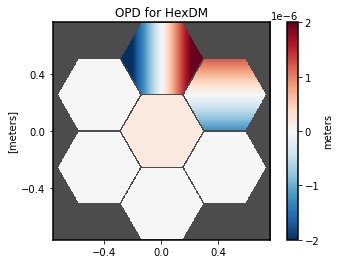

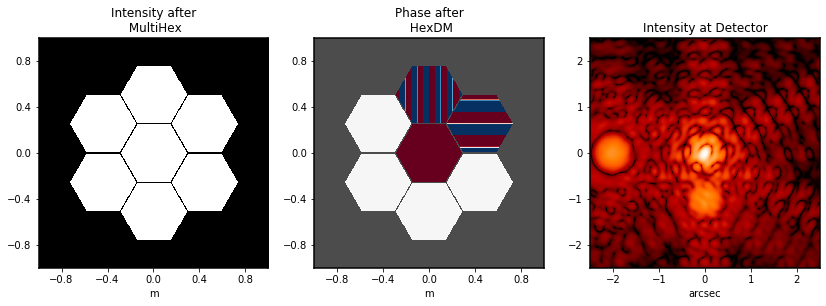

In [114]:
hexdm = poppy.HexSegmentedDeformableMirror(flattoflat=0.5*u.m, rings=1)
hexdm.set_actuator(0, 0.2*u.micron, 0, 0)  # piston
hexdm.set_actuator(1, 0, 2*u.arcsec, 0)    # tip
hexdm.set_actuator(2, 0, 0, 1*u.arcsec)    # tilt


osys2 = poppy.OpticalSystem(pupil_diameter=2*u.m)
#osys2.add_pupil(poppy.CircularAperture(radius=0.4*u.m))
osys2.add_pupil(poppy.MultiHexagonAperture(flattoflat=0.5*u.m, rings=1, center=True))
osys2.add_pupil(hexdm)
osys2.add_detector(0.010, fov_arcsec=10)


hexdm.display(what='opd', colorbar_orientation='vertical', opd_vmax=2e-6)

plt.figure(figsize=(14,5))
psf2, waves = osys2.calc_psf(display_intermediates=True, return_intermediates=True)

## Additional positive focus WFE moves the focus earlier (towards -z), and vice versa

We verify here that: 

1. A negative weak lens produces images (before focus) that have consistent orientation with the exit pupil
2. A positive weak lens produces images (after focus) that have the opposite orientation as the exit pupil
3. Images with the same magnitude but opposite signs of defocus should be 180 degree rotations of one another (for the simple case with no wavefront error).
    
We can do this with a letter-F shaped aperture for the parity test. 

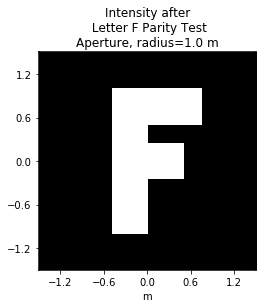

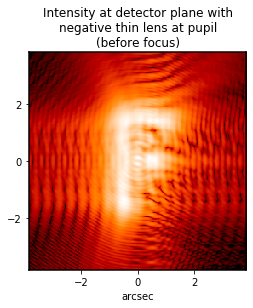

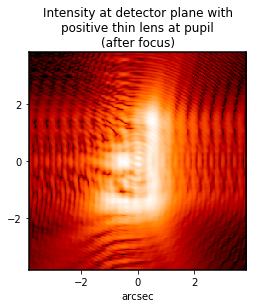

In [118]:
wave = poppy.Wavefront(diam=3*u.m)
wave *= poppy.LetterFAperture()
wave.display()
wave0 = wave.copy()
wave2 = wave.copy()

wave *= poppy.ThinLens(nwaves=-5)
wave.propagate_to(poppy.Detector(fov_pixels=256, pixelscale=0.03*u.arcsec/u.pixel))
plt.figure()
wave.display(imagecrop=30, title='Intensity at detector plane with\nnegative thin lens at pupil\n(before focus)')

wave2 *= poppy.ThinLens(nwaves=+5)
wave2.propagate_to(poppy.Detector(fov_pixels=256, pixelscale=0.03*u.arcsec/u.pixel))
plt.figure()
wave2.display(imagecrop=30, title='Intensity at detector plane with\npositive thin lens at pupil\n(after focus)')


def brighter_top_half(image):
    s = image.shape
    top = image[s[0]//2:].sum()
    bot = image[:s[0]//2].sum()
    return top > bot

def brighter_left_half(image):
    return not brighter_top_half(image.transpose())

assert brighter_top_half(wave0.intensity) and brighter_left_half(wave0.intensity), "Letter F should be brighter at top and left"

assert brighter_top_half(wave.intensity) and brighter_left_half(wave.intensity), "Image with negative lens (before focus) should have same orientation as the pupil "

assert (not brighter_top_half(wave2.intensity)) and (not brighter_left_half(wave2.intensity)), "Image with positive lens (after focus) should have opposite orientation as the pupil "

# For a automated unit test version of this, see poppy.tests.test_sign_conventions.test_pupil_orientations_before_and_after_focus

## Verify that a positive lens has positive WFE

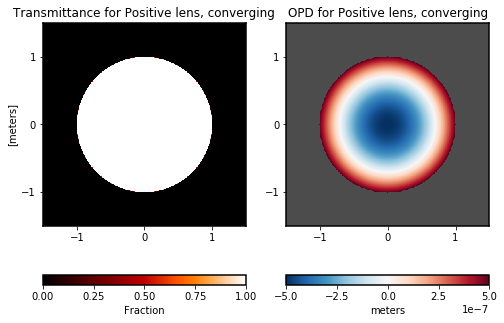

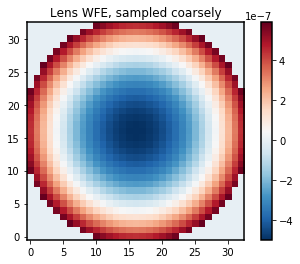

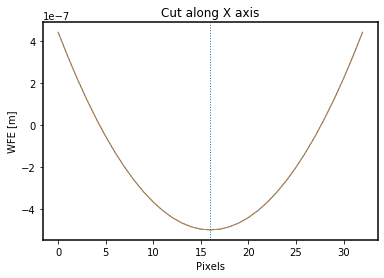

In [163]:
lens = poppy.ThinLens(name = "Positive lens, converging", nwaves=nwaves, radius=1)
plt.figure(figsize=(8,6))
lens.display(what='both')

nwaves = 1
npix =33  # use odd number so it passes exactly through the origin
lens_opd = poppy.ThinLens(nwaves=nwaves, radius=1).sample(what='opd', npix=npix, grid_size=2)

plt.figure()
plt.imshow(lens_opd, cmap=poppy.conf.cmap_diverging)
plt.colorbar()
plt.title("Lens WFE, sampled coarsely")
plt.figure()
plt.plot(lens_opd[lens_opd.shape[0]//2])

cen = (npix-1)//2
x = (np.arange(npix)-cen) / (npix/2)

y = nwaves*wave.wavelength.to_value(u.m) * x**2
y += lens_opd.min()

plt.plot(y, ls='--')
plt.axvline(cen, ls=":")
plt.xlabel("Pixels")
plt.ylabel("WFE [m]")
plt.title("Cut along X axis")

assert np.allclose(lens_opd[lens_opd.shape[0]//2], y), "Lens WFE did not match expectations for a positive lens" 

# work in progress and additional test dev below here...
Not polished yet. 

### Repeat DM test, in Fresnel propagation mode

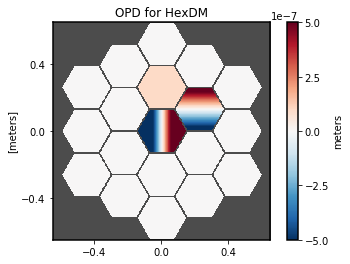

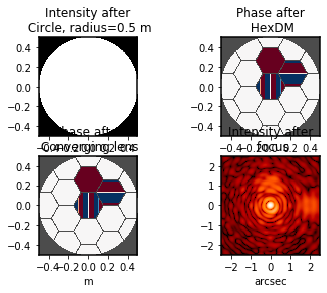

In [165]:
# Same thing, in Fresnel:
hexdm = poppy.HexSegmentedDeformableMirror(flattoflat=0.25*u.m, rings=2)
hexdm.set_actuator(0, 0, 2*u.arcsec, 0 )
hexdm.set_actuator(1, 0.1*u.micron, 0, 0 )
hexdm.set_actuator(2,  0, 0, 1*u.arcsec)



focal_length = 1.0*u.m
osys3 = poppy.FresnelOpticalSystem(pupil_diameter=1*u.m, beam_ratio=0.25)
osys3.add_optic(poppy.CircularAperture(radius=0.5*u.m))
osys3.add_optic(hexdm)
lens = poppy.QuadraticLens(f_lens=focal_length, name="Converging lens")
osys3.add_optic(lens)
osys3.add_optic(poppy.ScalarTransmission(planetype=poppy.poppy_core.PlaneType.image, 
                                        name='focus'), 
               distance=focal_length);


hexdm.display(what='opd', colorbar_orientation='vertical')

plt.figure()
psf2, waves = osys3.calc_psf(display_intermediates=True, return_intermediates=True)

0 0.999
1 0.999051282051282
2 0.9991025641025642
3 0.9991538461538462
4 0.9992051282051282
5 0.9992564102564102
6 0.9993076923076923
7 0.9993589743589744
8 0.9994102564102564
9 0.9994615384615384
10 0.9995128205128205
11 0.9995641025641026
12 0.9996153846153846
13 0.9996666666666666
14 0.9997179487179487
15 0.9997692307692307
16 0.9998205128205128
17 0.9998717948717948
18 0.9999230769230769
19 0.9999743589743589
20 1.000025641025641


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21 1.000076923076923


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


22 1.000128205128205


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


23 1.0001794871794871


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


24 1.0002307692307693


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


25 1.0002820512820512


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


26 1.0003333333333333


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


27 1.0003846153846152


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


28 1.0004358974358973


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


29 1.0004871794871795


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


30 1.0005384615384614


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


31 1.0005897435897435


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


32 1.0006410256410256


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


33 1.0006923076923075


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


34 1.0007435897435897


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


35 1.0007948717948716


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


36 1.0008461538461537


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


37 1.0008974358974358


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


38 1.0009487179487178


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


39 1.001


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


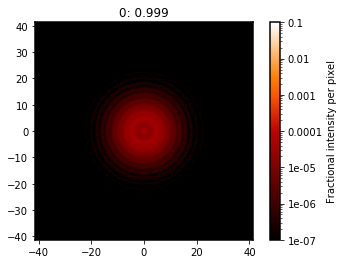

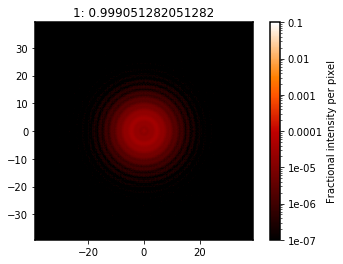

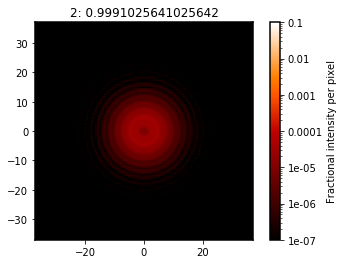

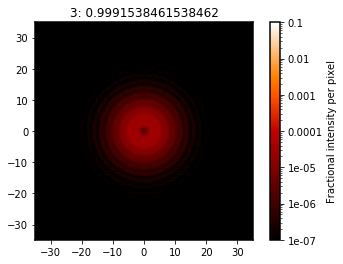

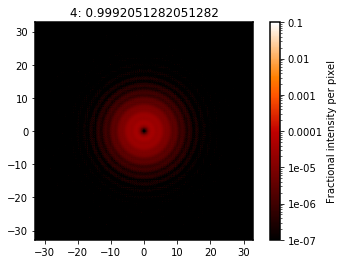

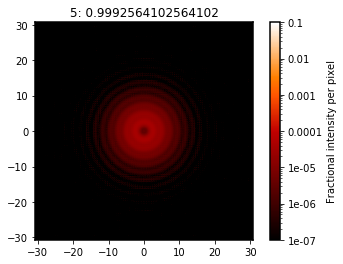

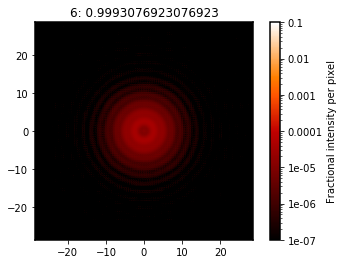

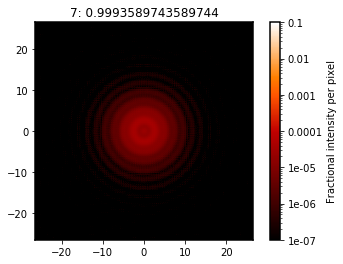

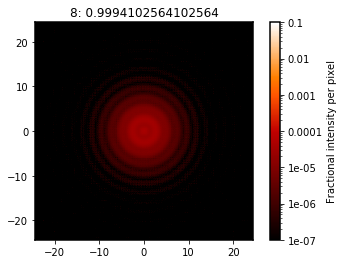

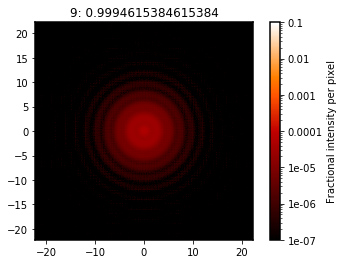

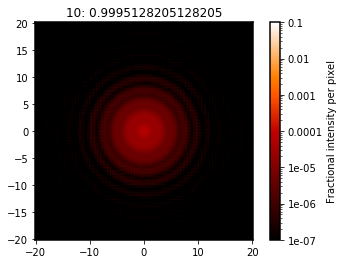

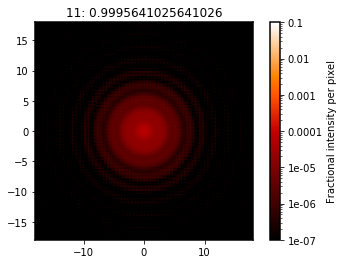

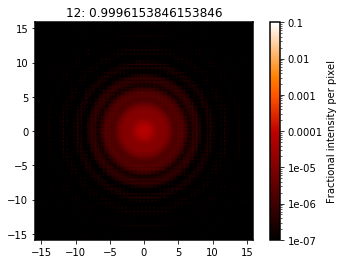

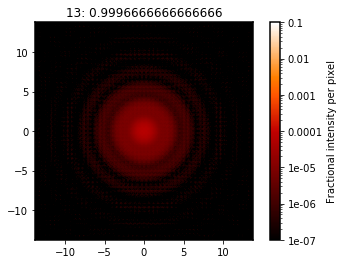

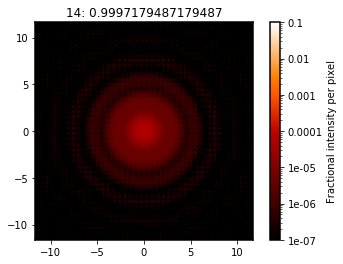

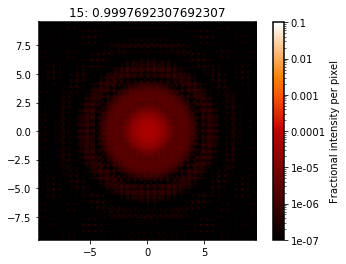

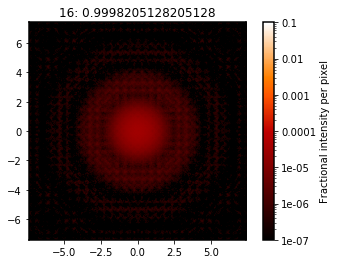

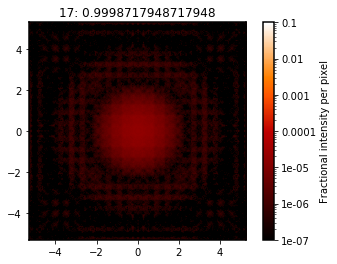

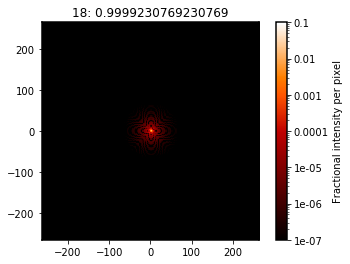

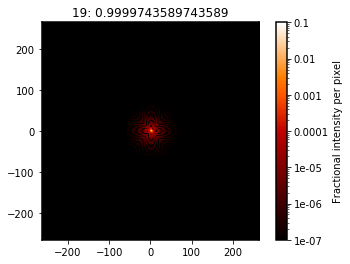

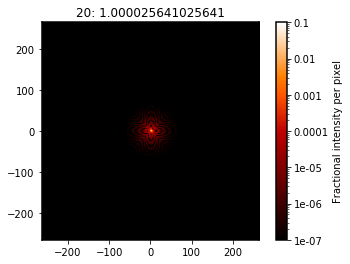

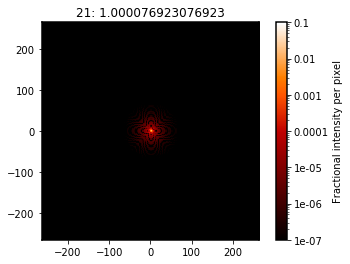

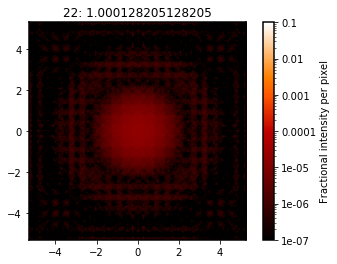

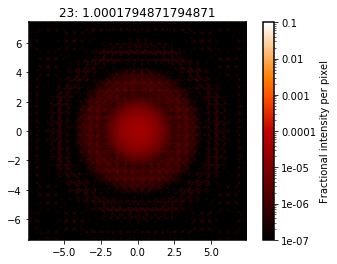

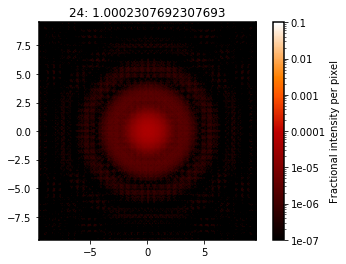

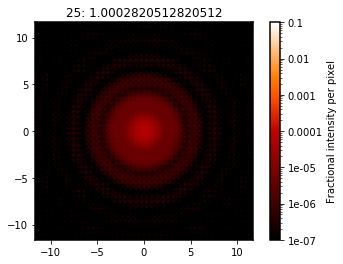

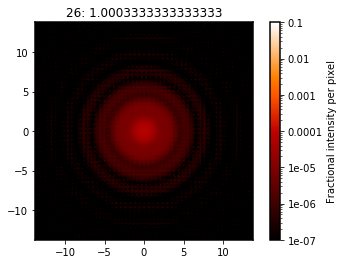

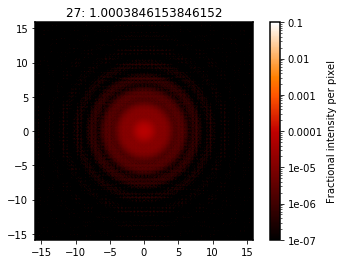

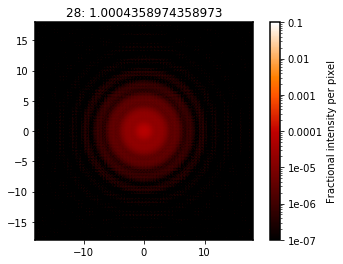

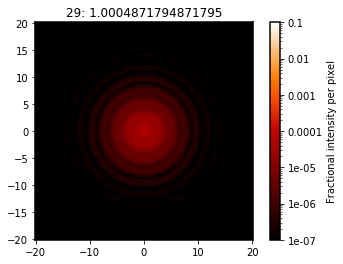

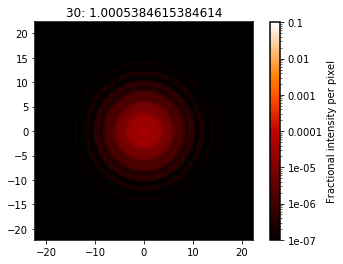

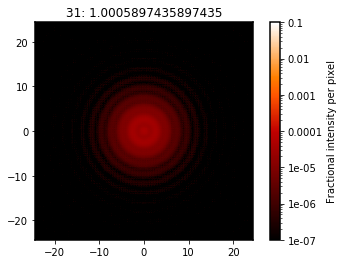

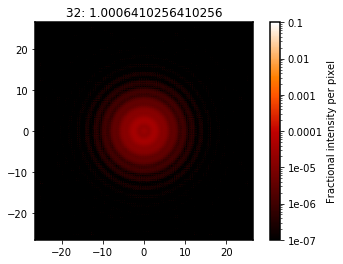

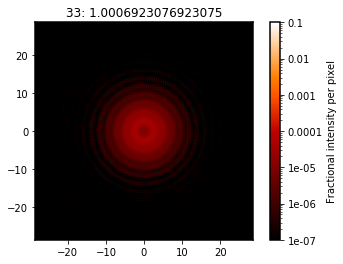

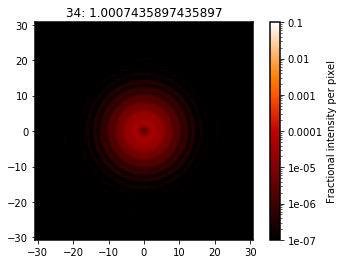

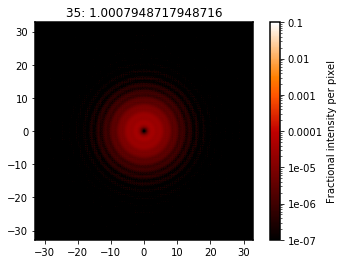

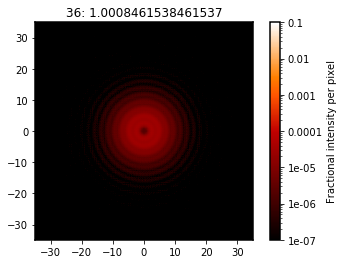

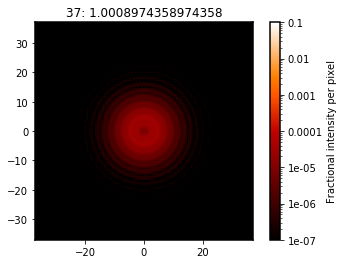

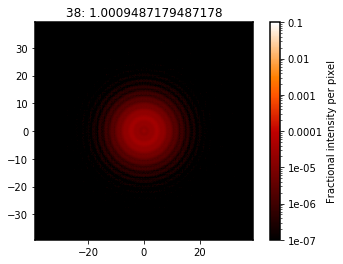

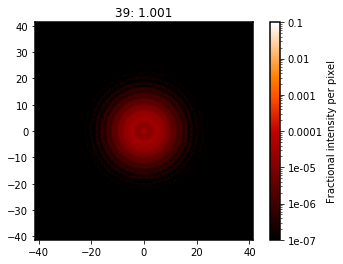

In [118]:
#def fresnel_through_focus(nsteps, range_scale=[0.9, 1.1]):

range_scale=[0.999, 1.001]

nsteps=40
nx = 1000
cuts = np.zeros((nx, nsteps))


for i, dist in enumerate(np.linspace(range_scale[0], range_scale[1], nsteps)):
    print(i,dist)
    osys = poppy.FresnelOpticalSystem(beam_ratio=0.25, pupil_diameter=10*u.cm, npix=256)
    osys.add_optic(poppy.CircularAperture(radius=0.05*u.m))
    osys.add_optic(poppy.QuadraticLens(f_lens=focal_length, name="Converging lens"))
    osys.add_optic(poppy.ScalarTransmission(planetype=poppy.poppy_core.PlaneType.image, 
                                            name='focus'), 
                   distance=dist*u.m);

    psf = osys.calc_psf(wavelength=1e-6)

    n = psf[0].data.shape

    plt.figure()
    poppy.display_psf(psf, imagecrop=10000, title=f'{i}: {dist}')
    
    cuts[:,i] = psf[0].data[n[0]//2, n[1]//2-nx//2:n[1]//2+nx//2]



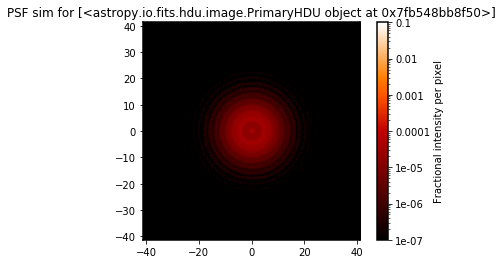

In [113]:
poppy.display_psf(psf, imagecrop=10000)

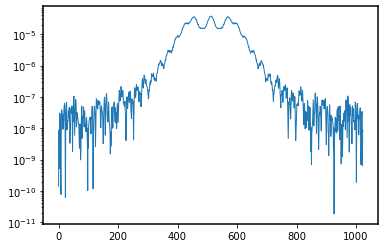

In [114]:
plt.semilogy(psf[0].data[n[0]//2, n[1]//2-nx*3:n[1]//2+nx*3])

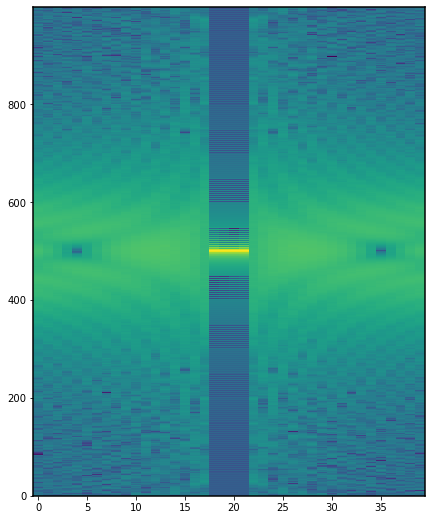

In [117]:
plt.figure(figsize=(9,9))
plt.imshow(np.log10(cuts))
plt.gca().set_aspect(0.05)

(472, 552)

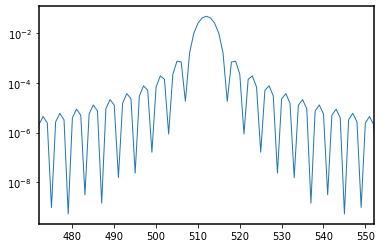

In [67]:
plt.semilogy(psf[0].data[n[0]//2])
plt.xlim(n[0]//2-ny//2, n[0]//2+ny//2)

In [57]:
waves[2].location

'at Detector'

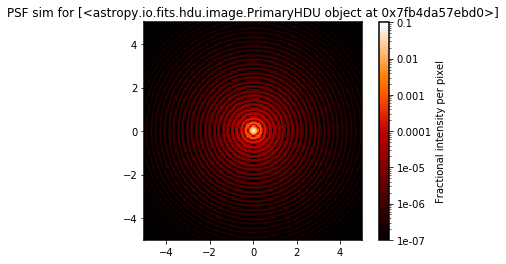

In [61]:
poppy.display_psf(psf, imagecrop=10)

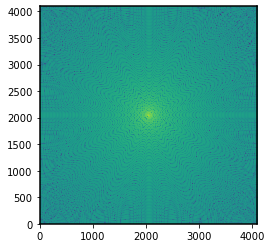

In [5]:
plt.imshow(np.log10(waves[2].intensity))

both 4.9116737424958396e-08 0.049116737424958395


(<matplotlib.axes._subplots.AxesSubplot at 0x7fb4d98c3a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb4e8a491d0>)

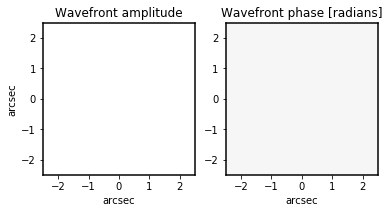

In [6]:
waves[2].display(what='both')

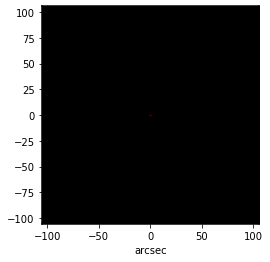

In [7]:
psf, waves = osys.calc_psf(wavelength=1*u.micron, display=True, return_intermediates=True)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb539857c90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb53984ec90>)

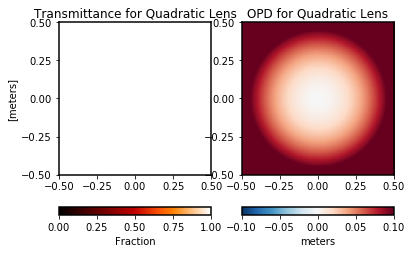

In [8]:
poppy.QuadraticLens(f_lens=focal_length).display(what='both', opd_vmax=0.1)

both 0 1.2150709379508709e-06


(<matplotlib.axes._subplots.AxesSubplot at 0x7fb5485278d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb548535b90>)

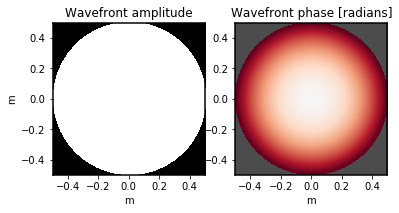

In [9]:
waves[1].display(what='both')

phase 1e-06 1e-06


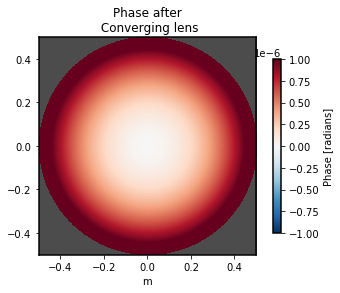

In [10]:
waves[1].display(what='phase',vmax=1e-6, vmin=1e-6, colorbar=True)

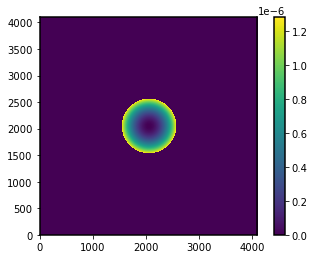

In [11]:
plt.imshow(waves[1].phase)
plt.colorbar()

In [12]:
waves[0].__class__

poppy.fresnel.FresnelWavefront

phase 0.25 0.25


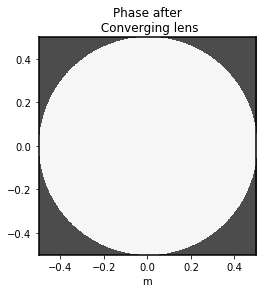

In [13]:
waves[1].display(what='phase')

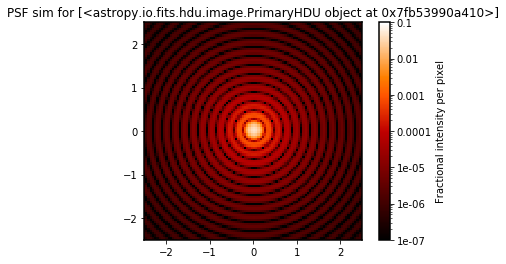

In [14]:
poppy.display_psf(psf, imagecrop=5)

wfe 0 1.2150320735340663e-06


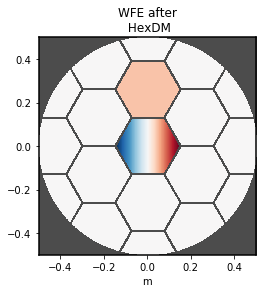

In [47]:
waves[1].display(what='wfe')

(-0.5, 0.5)

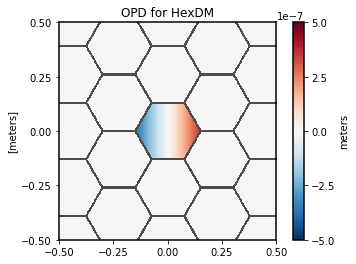

In [45]:
wave = osys2.input_wavefront()
wave *= hexdm


hexdm.display(what='opd', npix=1024, colorbar_orientation='vertical')
plt.gca().set_xlim(-0.5, 0.5)
plt.gca().set_ylim(-0.5, 0.5)

